# Martin2019
# Standard scanpy workflow version 2.8 #

### Import section ###

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

./.conda/envs/besca_test/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.5.post2 anndata==0.7.1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.24.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.2 louvain==0.6.1


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [2]:
# decisions to be made
species = 'human'
batch_to_correct = 'Subject' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'standard_workflow_besca2_0'
split_condition='Sample_geo_accession' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]
    
#additional labeling
labeling_to_use = 'Subtype' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'Martin2019_Subtype' # define name under which the labeling should be exported
labeling_description = 'celltype annotation from authors [Martin2019].' #define description which should be saved to labeling_info file
labeling_author = 'Martin et al' #define author which shoudl be saved to labeling info file

### Define Input ###

In [3]:
# define filepath (this is the folder that contains "raw" and "analyzed")
#root_path = os.getcwd()
root_path = './'

### Standard parameters - these should be kept as stable as possible ###

In [4]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 30
standard_min_counts = 1000
standard_n_genes = 6000 # this is the most tricky one to set
standard_percent_mito = 0.2
standard_max_counts = 50000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [5]:
#define standardized filepaths based on above input
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

#read input data
#adata = bc.st.read_matrix(root_path)
adata = bc.datasets.Martin2019_raw()

LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2020-05-12
LOG MESSAGE: Analysis 'standard_workflow_besca2_0' on data located in'./'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: Subject
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 6000
LOG MESSAGE: 	standard_max_counts = 50000
LOG MESSAGE: 	standard_percent_mito = 0.2
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.103s


all output directories created successfully


In [6]:
adata

AnnData object with n_obs × n_vars = 120316 × 33694 
    obs: 'CELL', 'CONDITION', 'Sample_geo_accession', 'Sample_title', 'Subject', 'tissue', 'status', '10x chemistry', 'Sample_relation', 'Sample_relation_2', 'Sample_supplementary_file_1', 'Sample_supplementary_file_2', 'Sample_supplementary_file_3', 'ID_REF', 'Barcode', 'Type', 'Cluster', 'Lane', 'Subtype'
    var: 'ENSEMBL', 'SYMBOL'

In [7]:
#calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species=species)

### Visualization of quality control plots and selected filtering parameters

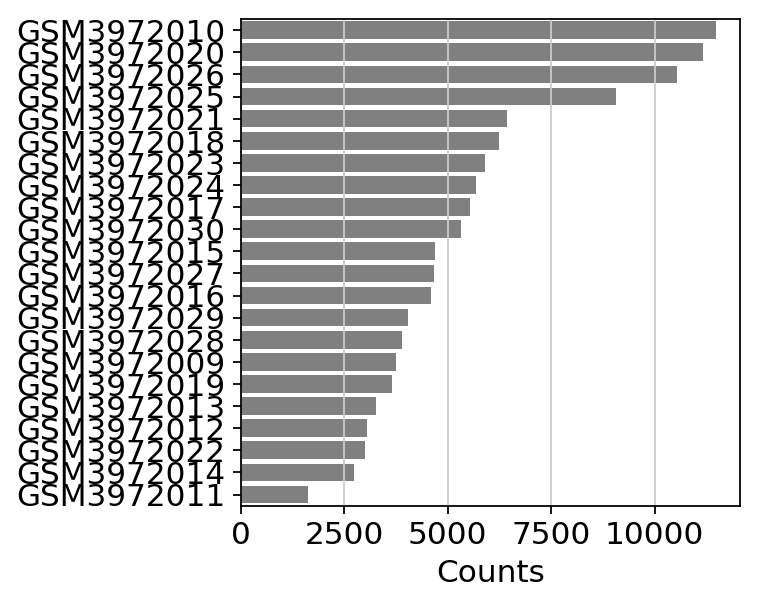

In [8]:
### have a look at cell nrs per sample ### 
temp=bc.tl.count_occurance(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

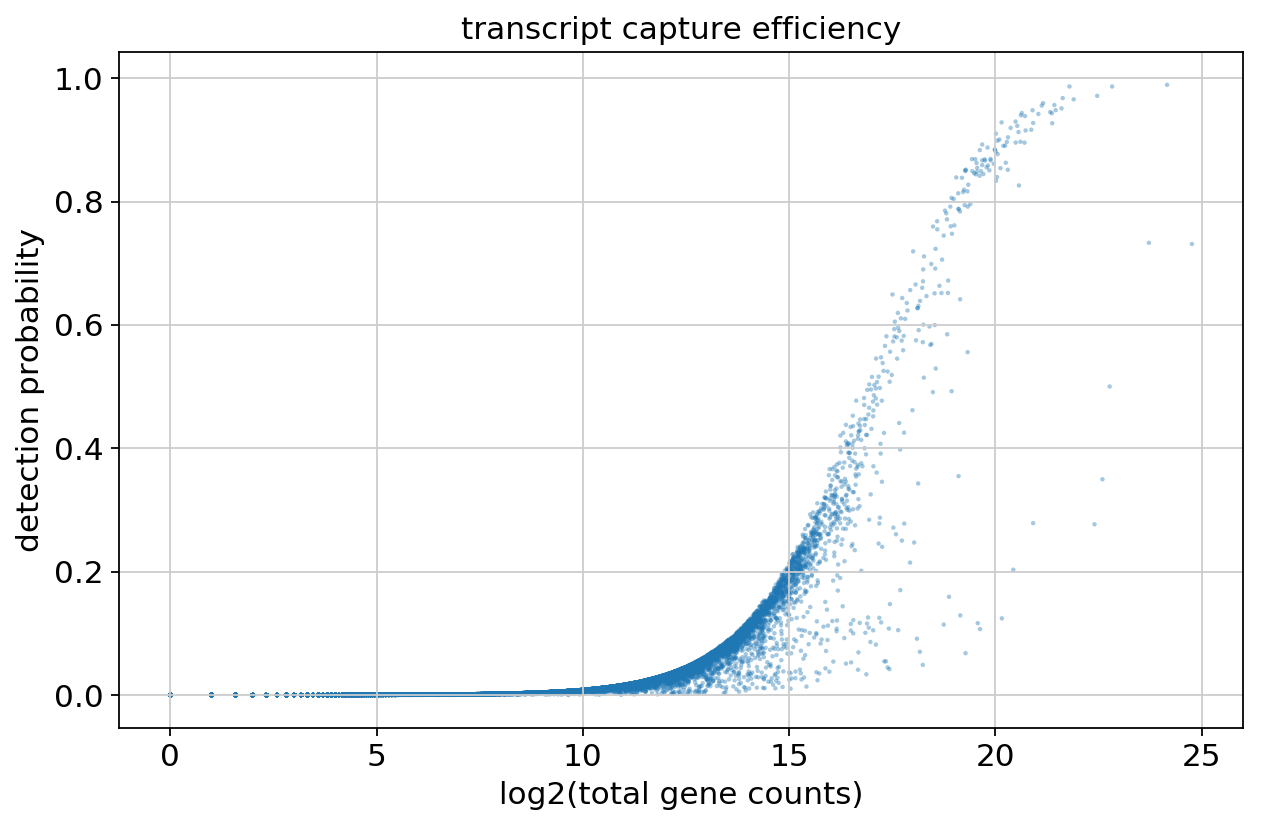

In [9]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

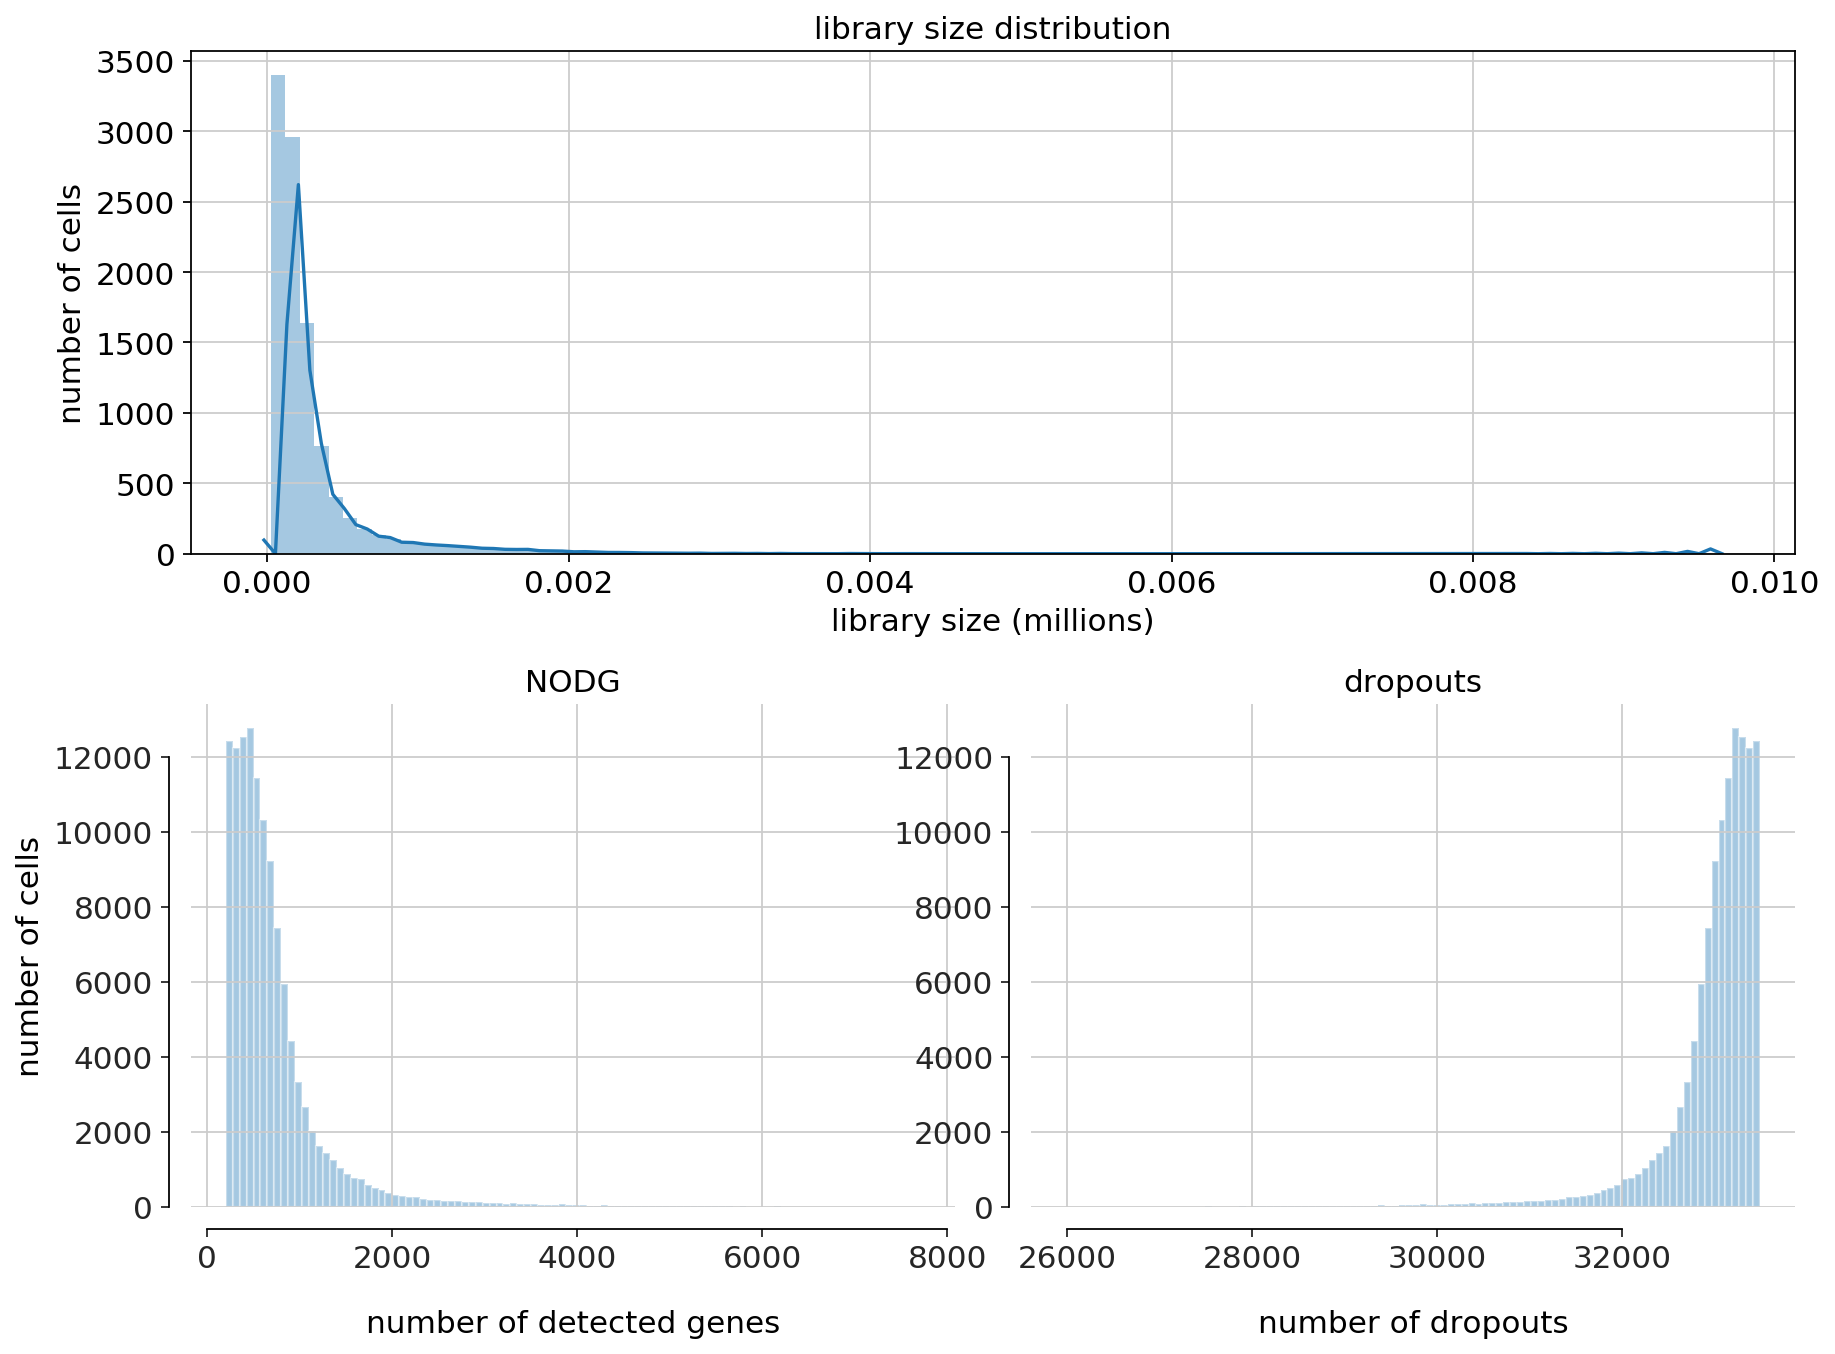

In [10]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [11]:
adata_unfiltered = adata.copy()

##### Selected Filtering Parameters

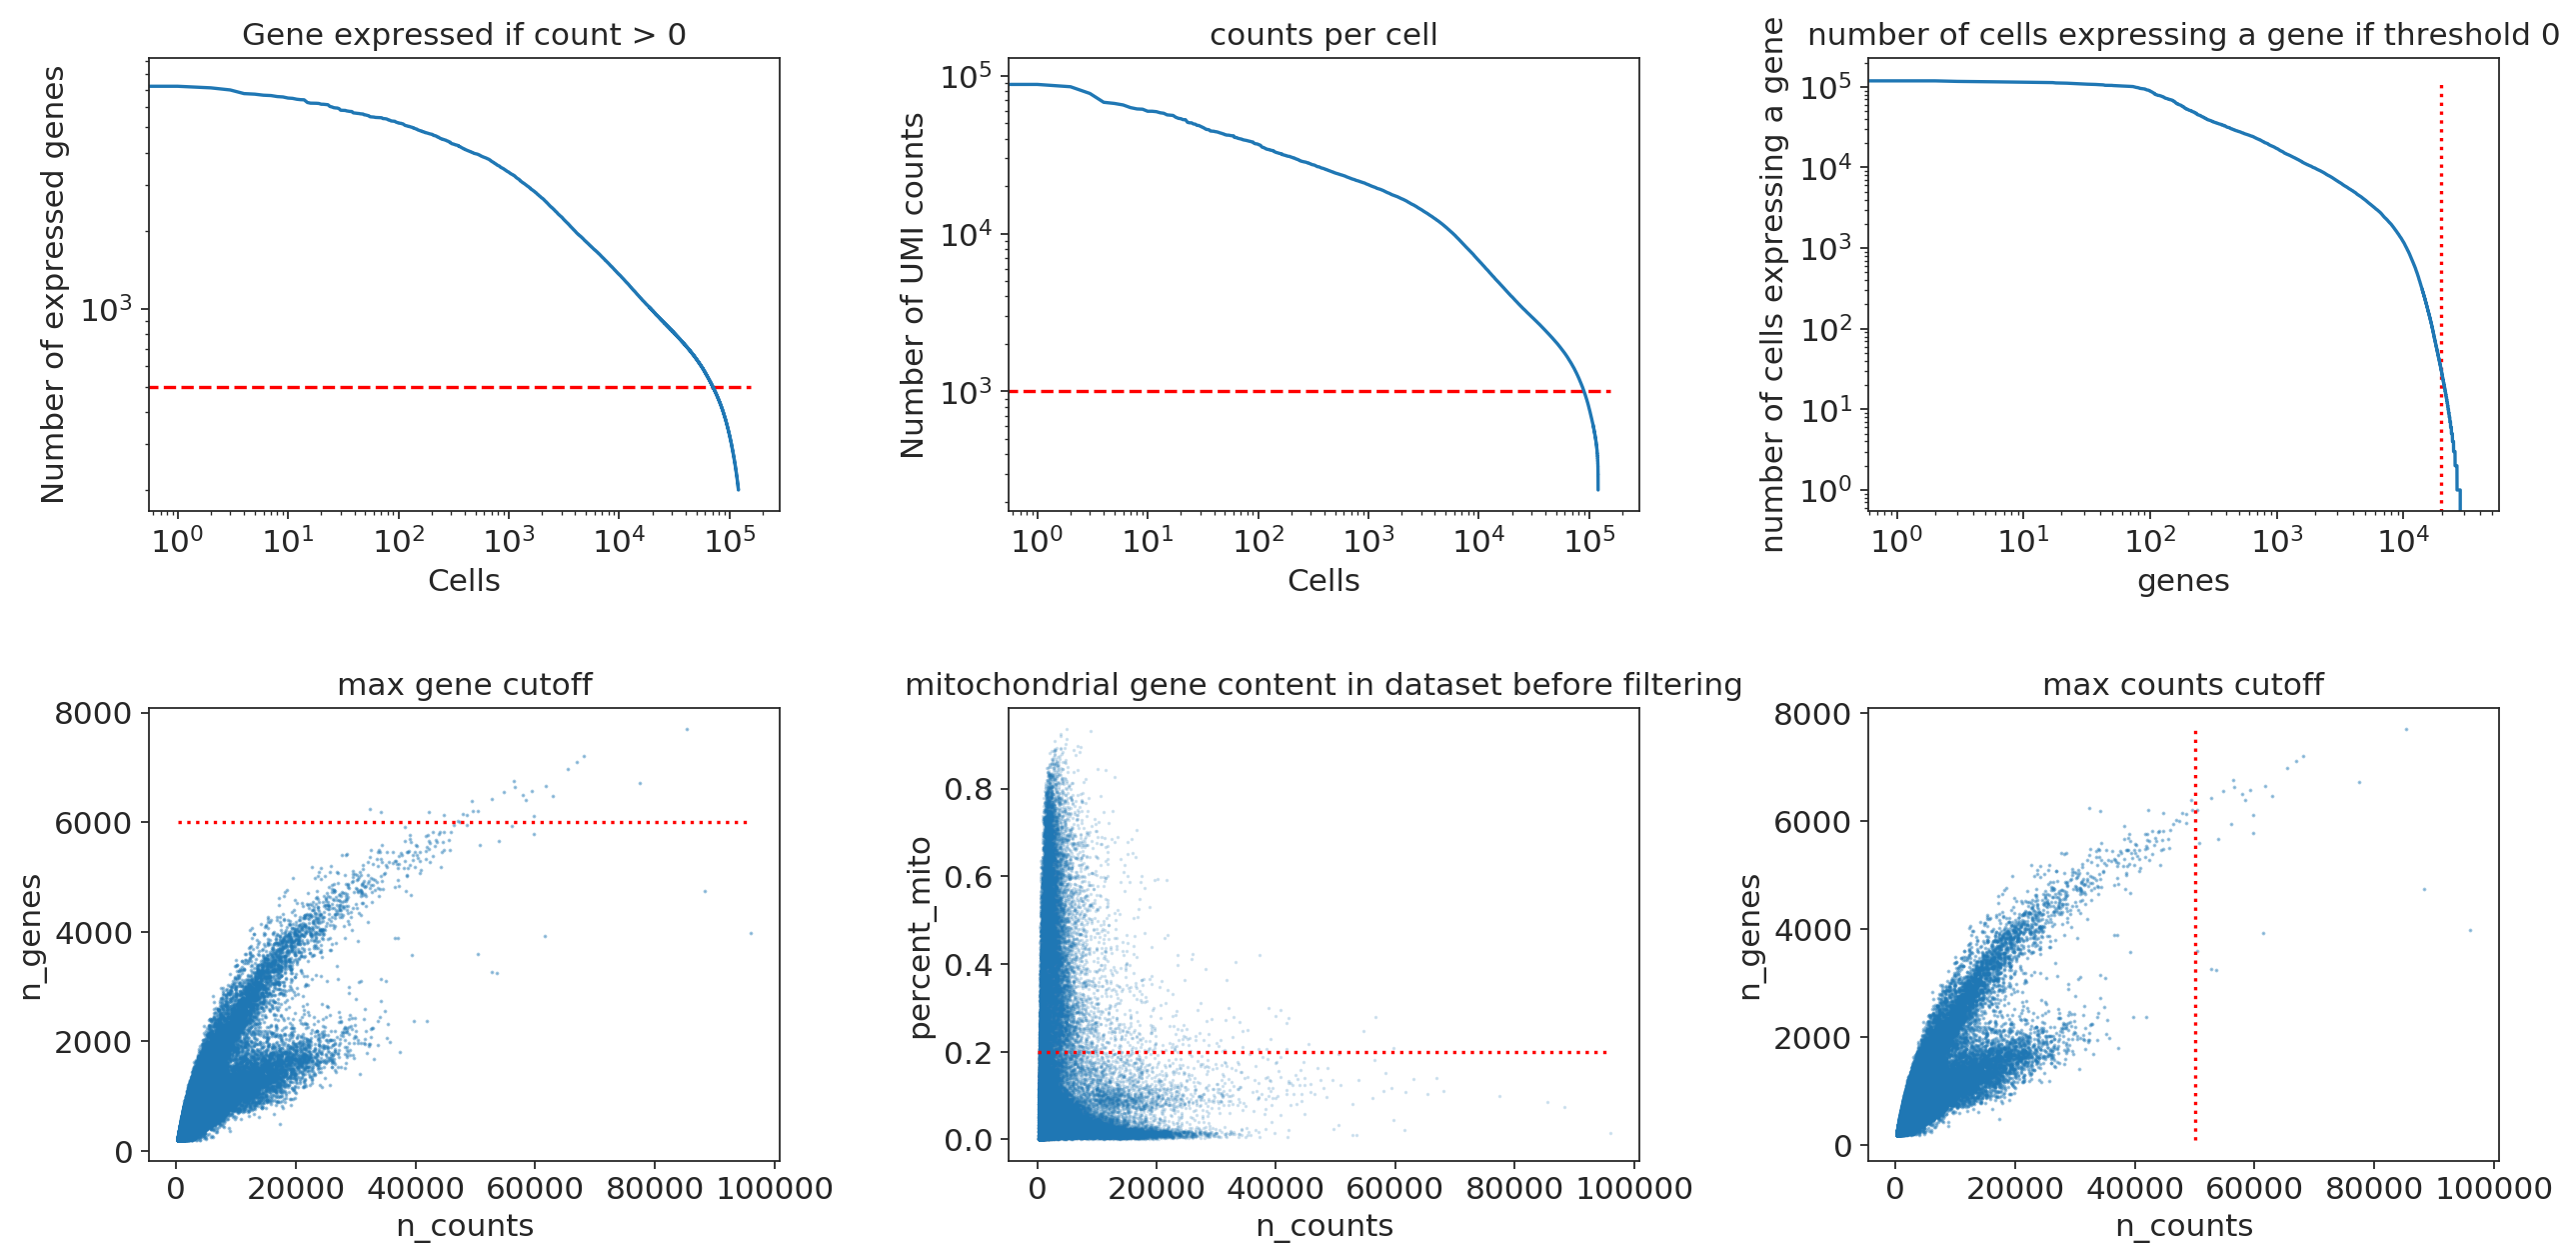

In [12]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

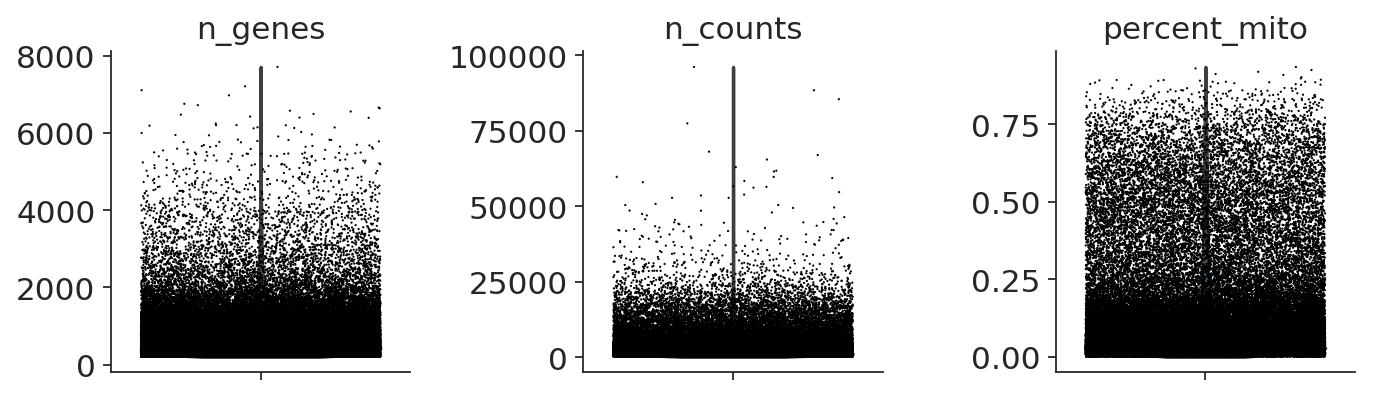

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

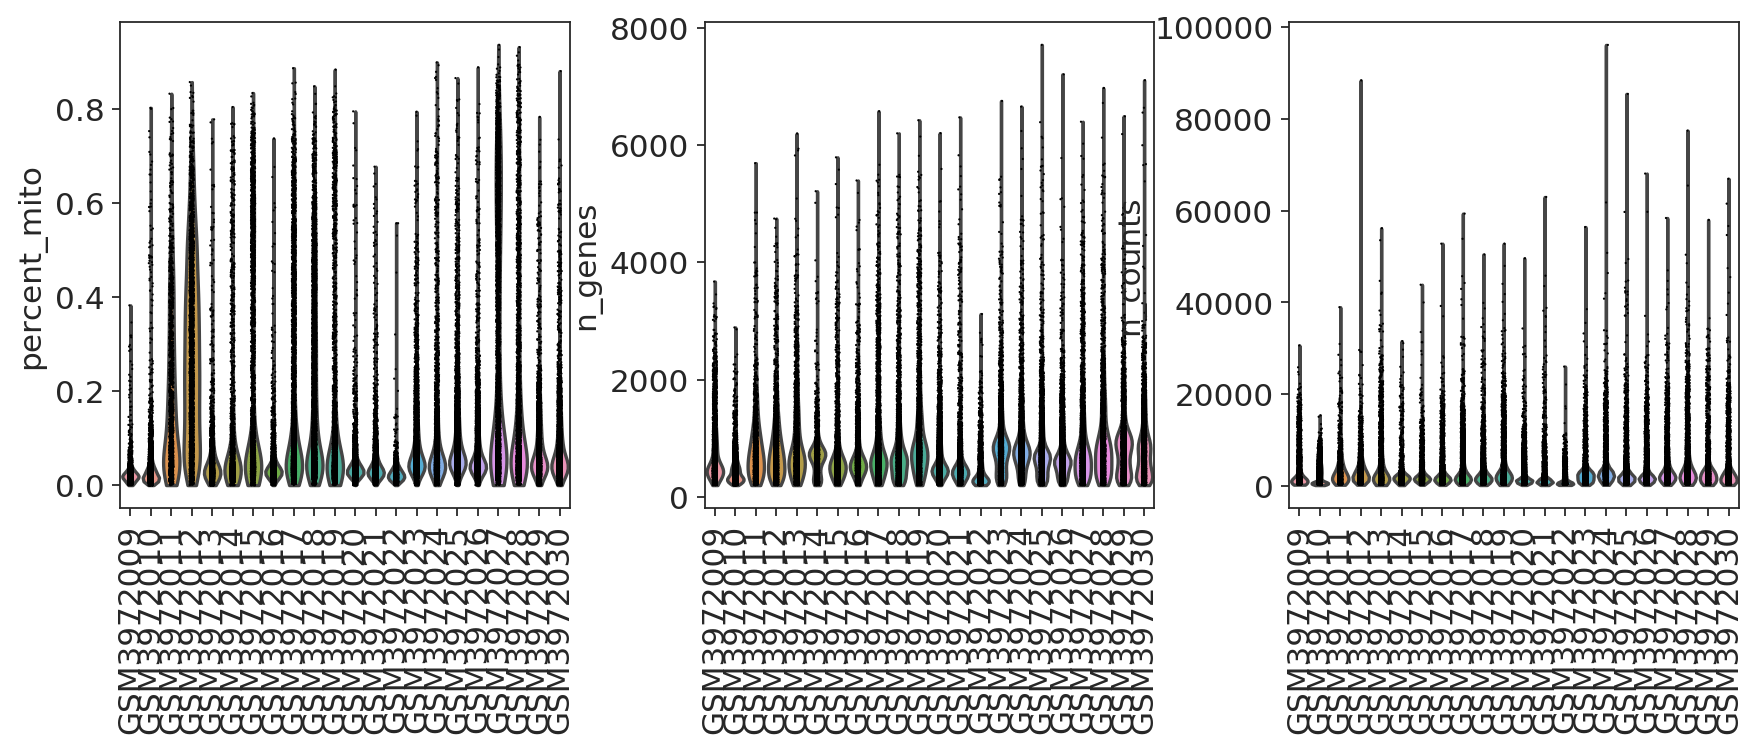

In [14]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### First filtering on gene and cell counts

In [15]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 70140 cells, 19924 genes
LOG MESSAGE: 	Time for filtering: 2.073s


In [16]:
filtering1.show()

started with  120316  total cells and  33694  total genes
removed 49792 cells that did not express at least 500  genes
removed 384 cells that did not have at least 1000 counts
removed 13770 genes that were not expressed in at least 30 cells
finished with 70140  total cells and 19924 total genes


### Second filtering on mitochondrial genes, and upper limit for gene number ###

In [17]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 62202 cells, 19924 genes
LOG MESSAGE: 	Time for filtering: 1.167s


In [18]:
filtering2.show()

started with  70140  total cells and  19924  total genes
removed 25 cells that expressed more than 6000 genes
removed 10 cells that had more than 50000  counts
removed  7903  cells that expressed  20.0 percent mitochondrial genes or more
finished with 62202  total cells and 19924 total genes


###  Filtered dataset characteristics

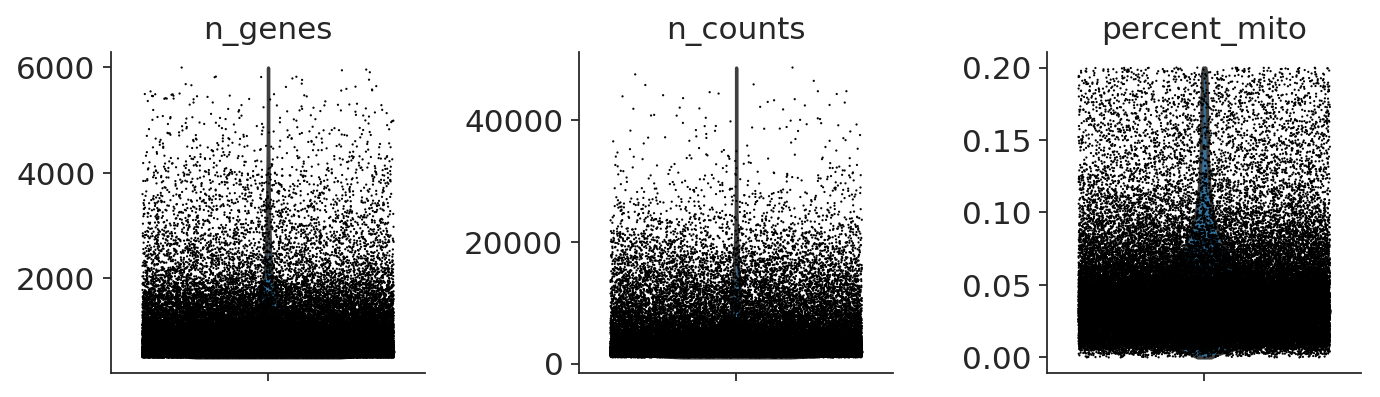

In [19]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

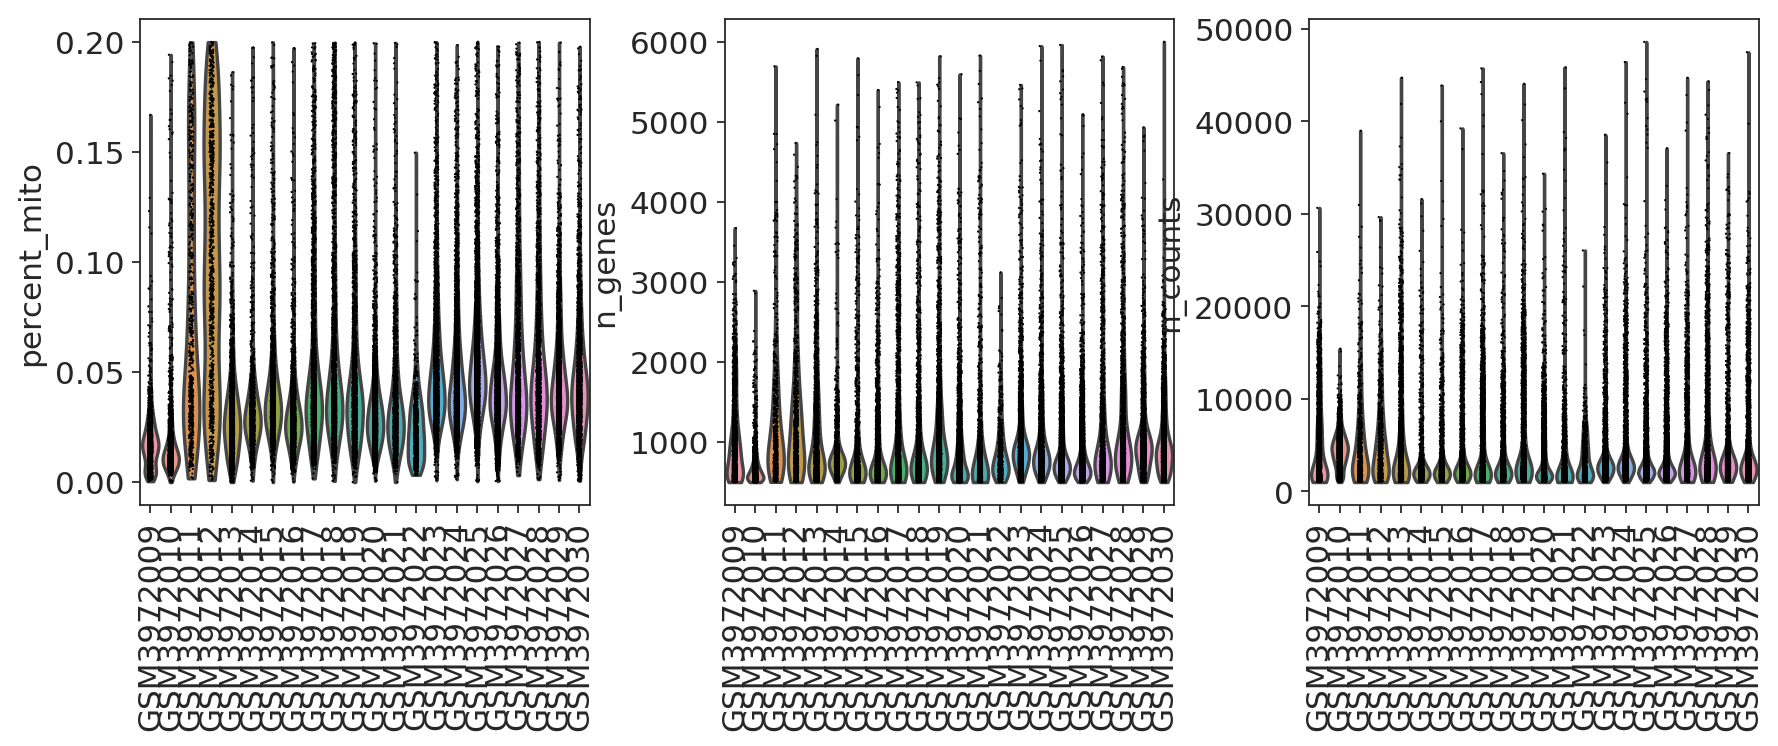

In [20]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

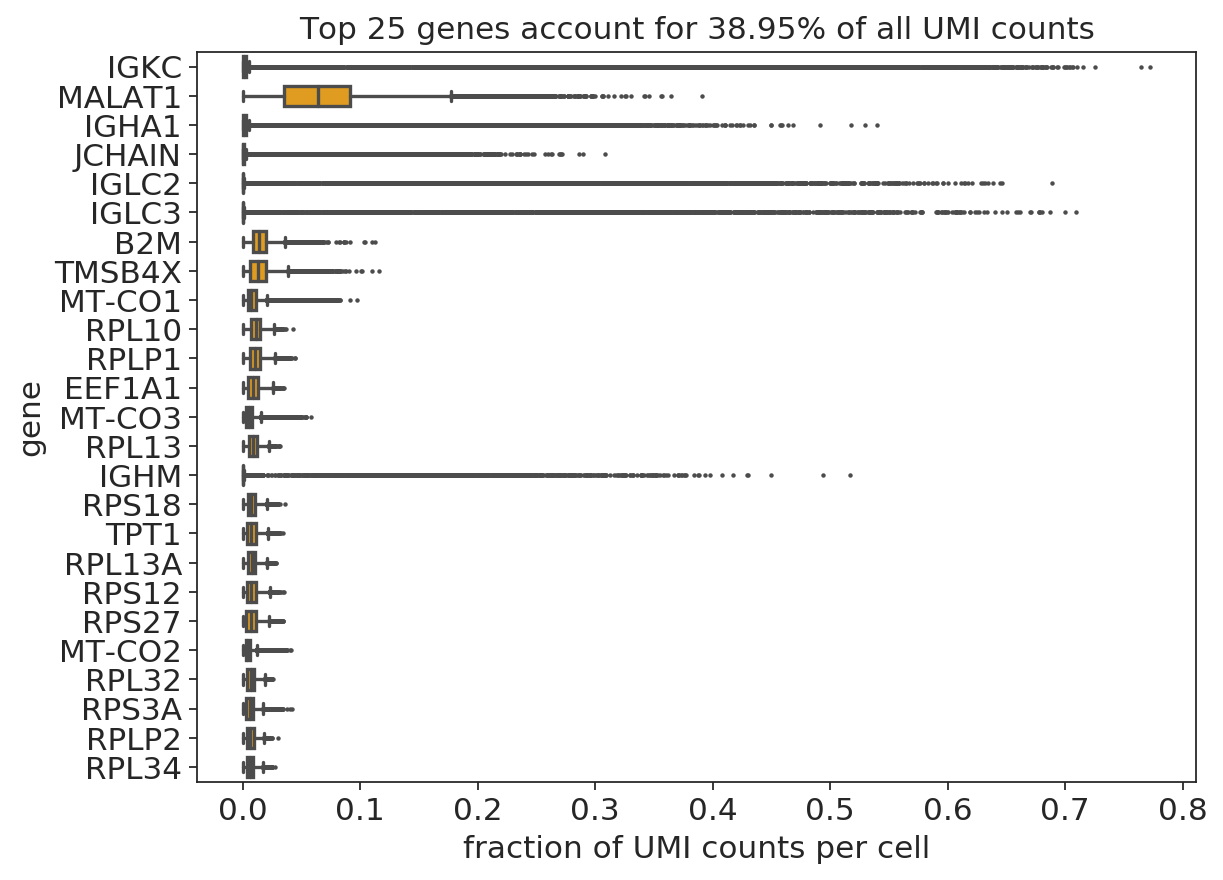

In [21]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization, and output of normalized results ###

In [22]:
adata = bc.st.per_cell_normalize(adata, results_folder)

adata normalized per cell


LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 1.762s


log1p values saved into adata.raw
writing out matrix.mtx ...
adata.X successfully written to matrix.mtx. 
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv


LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: 	Time for cp10k export: 128.473s


annotation successfully written out to metadata.tsv


CTCF can not be plotted


<Figure size 320x320 with 0 Axes>

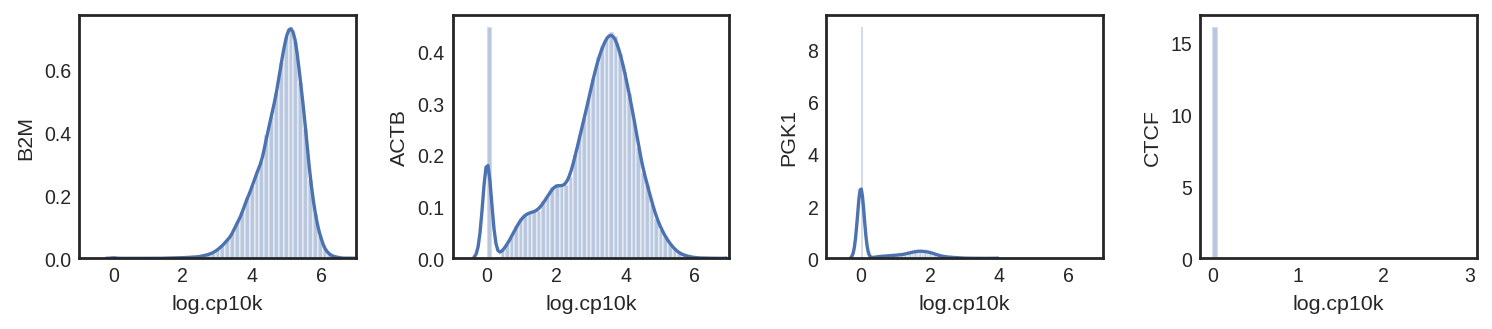

In [23]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
    except:
        print( myg + ' can not be plotted')
    ax.set(xlabel='log.cp10k',ylabel=myg)
    g.set_xlim(-1, 7)


### Feature selection (highly variable genes) for clustering ###

log1p taken of adata


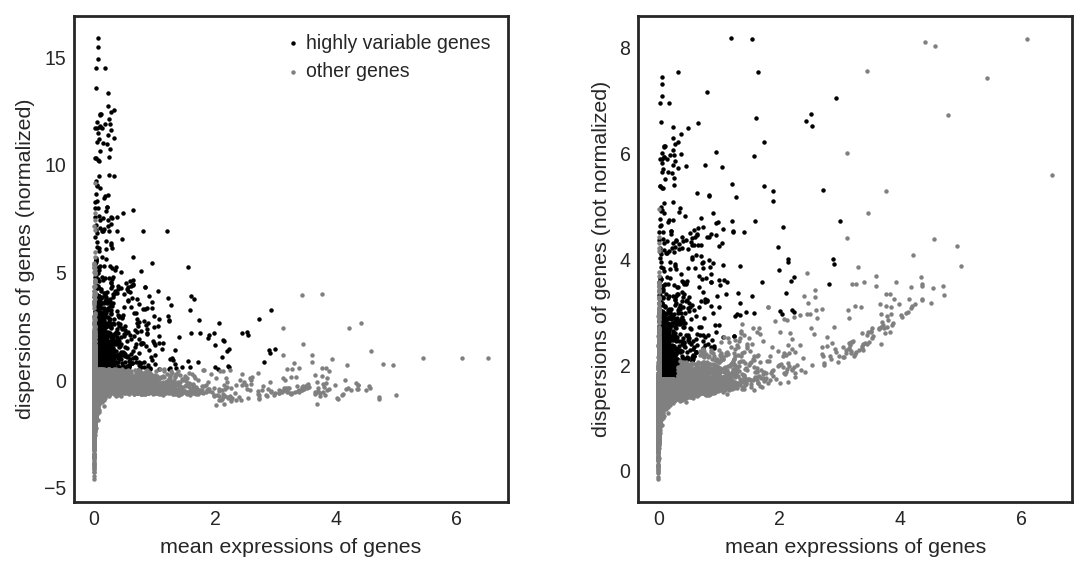

LOG MESSAGE: After feature selection of highly variable genes: 62202 cells, 1417 genes
LOG MESSAGE: 	Time for feature selection: 5.207s


In [24]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [25]:
adata 

View of AnnData object with n_obs × n_vars = 62202 × 1417 
    obs: 'CELL', 'CONDITION', 'Sample_geo_accession', 'Sample_title', 'Subject', 'tissue', 'status', '10x chemistry', 'Sample_relation', 'Sample_relation_2', 'Sample_supplementary_file_1', 'Sample_supplementary_file_2', 'Sample_supplementary_file_3', 'ID_REF', 'Barcode', 'Type', 'Cluster', 'Lane', 'Subtype', 'percent_mito', 'n_counts', 'n_genes'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'log1p'

In [26]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

'n_counts' and 'percent_mito' regressed out


LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: 	Time for regression steps: 42.223s


adata scaled with max_value set to 10


### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


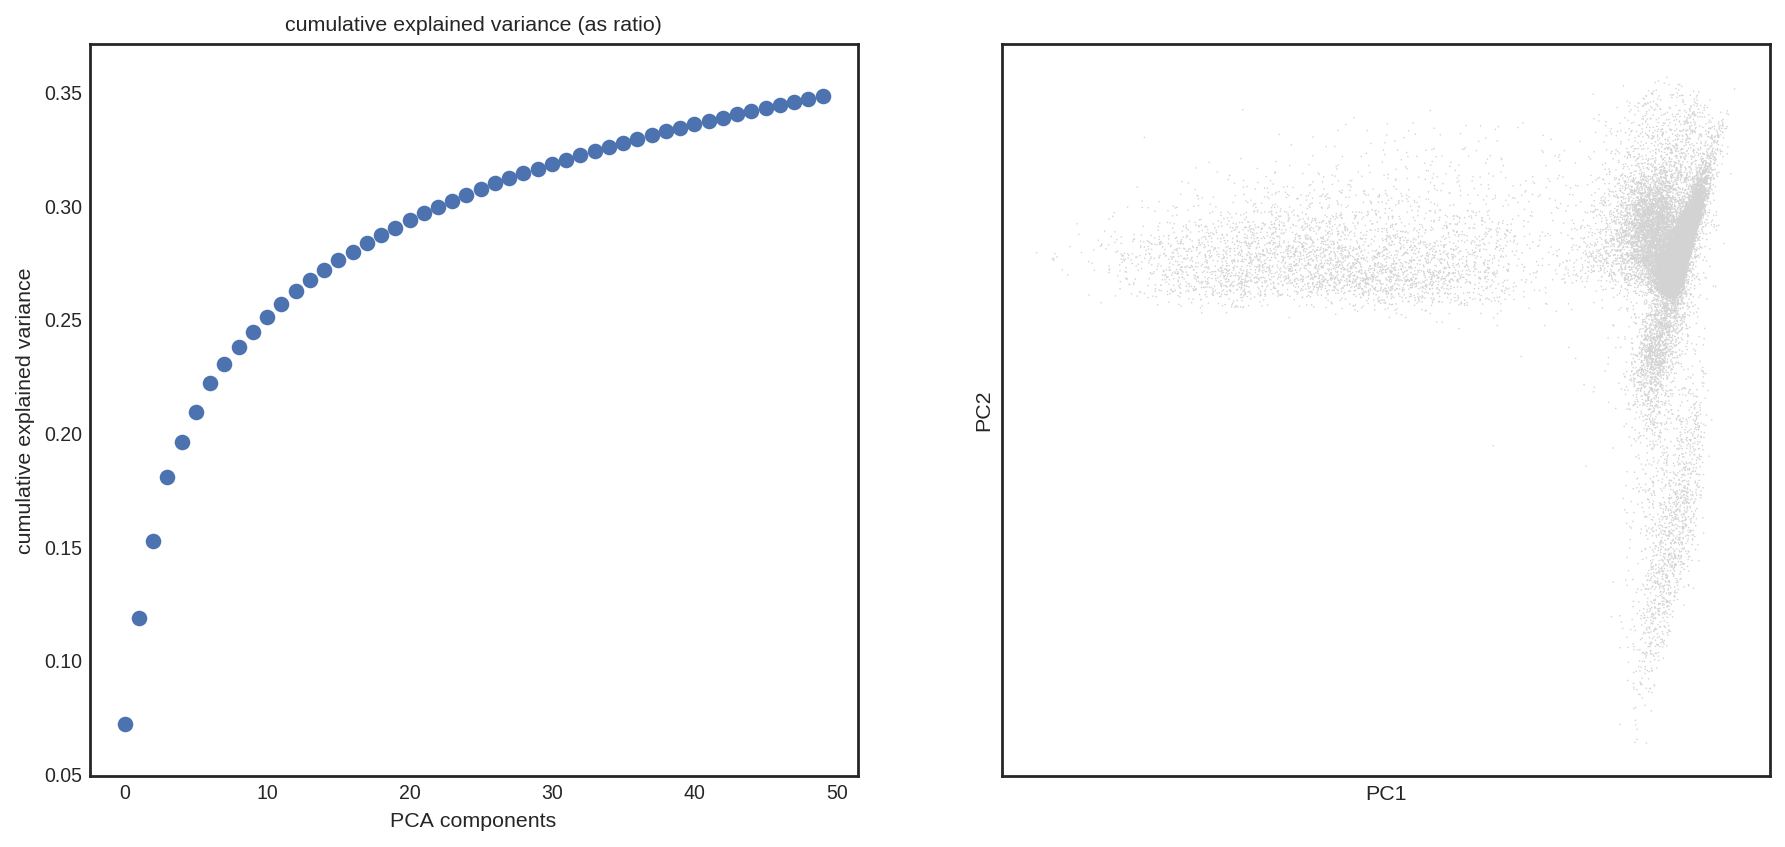

LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 142.903s


UMAP coordinates calculated.


LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.585s


results successfully written out to 'analysis_metadata.tsv'


In [27]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1


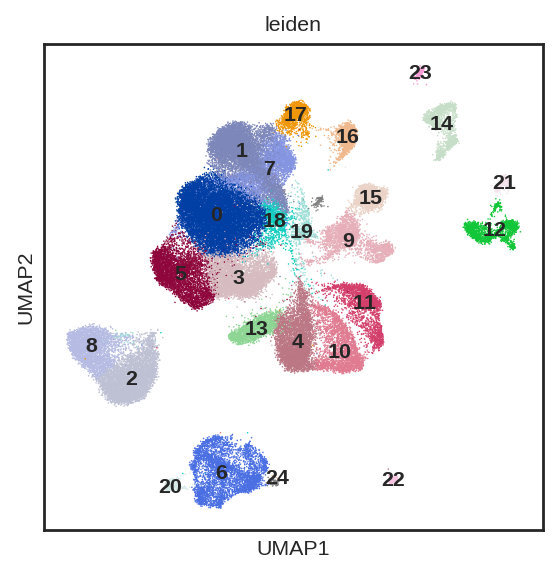

LOG MESSAGE: leidenclustering done. Found 25 clusters.
LOG MESSAGE: 	Time for leiden clustering: 98.633s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 94.371s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./analyzed/standard_workflow_besca2_0/labelings/leiden/WilxRank.gct written out
./analyzed/standard_workflow_besca2_0/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 7.886s


./analyzed/standard_workflow_besca2_0/labelings/leiden/WilxRank.logFC.gct written out


In [28]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [29]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

./analyzed/standard_workflow_besca2_0/standard_workflow_besca2_0.h5ad


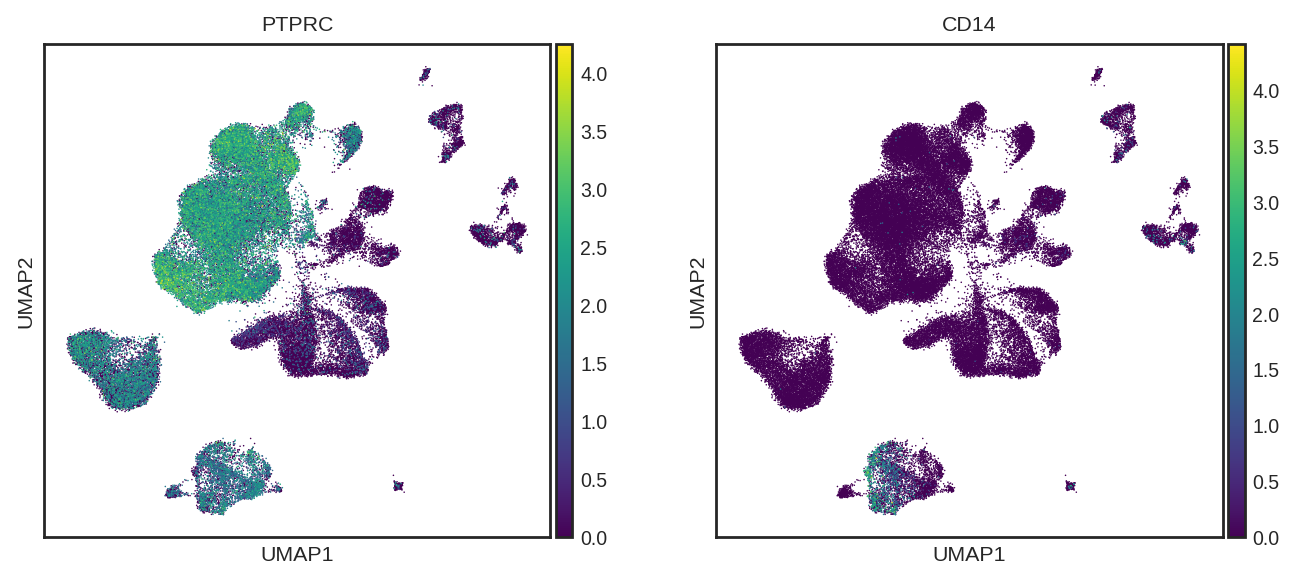

In [30]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [31]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 102.177s


rank genes per label calculated using method wilcoxon.
mapping of cells to  Subtype exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./analyzed/standard_workflow_besca2_0/labelings/Martin2019_Subtype/WilxRank.gct written out
./analyzed/standard_workflow_besca2_0/labelings/Martin2019_Subtype/WilxRank.pvalues.gct written out


LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 9.913s


./analyzed/standard_workflow_besca2_0/labelings/Martin2019_Subtype/WilxRank.logFC.gct written out


### Complete log-file

In [32]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 759.507s


### Write QC Report

In [33]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html
